<a href="https://colab.research.google.com/github/Emerson-Costa/reconhecimento-especies-plantas/blob/main/trabalhoFinalFRK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libs do Projeto

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix, classification_report
# Biblioteca fornecida para o download do dataset deste trabalho
import kagglehub

1. Iniciando o Download do Dataset **Flowers Recognition**

In [ ]:
print("Iniciando o domnload do dataset 'Flowers Recognition'...")
try:
  path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
  DATA_DIR = os.path.join(path, "flowers")
  print(f"Dataset baixado com sucesso. Path: {DATA_DIR}")
except Exception as e:
  print(f"Erro ao baixar o dataset. Erro: {e}")
  exit()

Iniciando o domnload do dataset 'Flowers Recognition'...


100%|██████████| 225M/225M [00:01<00:00, 162MB/s]

Extracting files...


Dataset baixado com sucesso. Path: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers


1.1. Configurando o Dispositivo (GPU) e a Definição do Modelo

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 5 Classes: Daisy, Dandelion, Rose, Sunflower, Tulip
NUM_CLASSES = 5
BATCH_SIZE = 32
IMAGE_SIZE = 224

2. Pré Processamento e Data Augmentation

In [ ]:
# Transformações para o conjunto de treinamento (Data Augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalização padrão ImageNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

2.1 Transformações para Validação e Teste

In [ ]:
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

2.2 Carregamento e Partição dos dos Dados (80 ; 10; 10)

In [ ]:
from torch._higher_order_ops.invoke_subgraph import trace_joint_graph_as_bwd
from ctypes.util import test
full_dataset = datasets.ImageFolder(DATA_DIR, train_transforms)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

# Aqui eu estou garantindo que a soma seja igual ao total
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Aplicando as transformações corretas para os conjuntos de validação e teste
val_dataset.dataset.transforms = val_test_transforms
test_dataset.dataset.transforms = val_test_transforms

# Cria os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = full_dataset.classes
print(f"Número total de imagens: {total_size}")
print(f"Classes identidifadas: {class_names}")

Número total de imagens: 4317
Classes identidifadas: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


3. Treinamento do Modelo (Transfer Learning)

In [ ]:
# Arquitetura: ResNet18 pré-treinada
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelando os paâmetros do modelo base
for param in model.parameters():
    param.requires_grad = False

# Adaptando a camada final
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# Entropia Cruzada
criterion = nn.CrossEntropyLoss()

# Taxa de aprendizado baixa para evitar que os pesos pré-treinados sejam corrompidos
optmizer = optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 15


print(f"Iniciando o treinamento  classificada por {NUM_EPOCHS} épocas...")

def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Loop principal de treinamento e validação"""
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iniciando o treinamento
        for inputs, labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optmizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Fazendo a Validação
        model.eval()
        val_corrects = 0
        with torch.no_grad():
          for inputs, labels in val_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Treino Loss: {epoch_loss:.4f} | Treino Acc: {epoch_acc:.4f} | Validação Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model_flowers.pth")

    model.load_state_dict(torch.load("best_model_flowers.pth"))
    return model

final_model = train_model(model, criterion, optmizer, num_epochs=NUM_EPOCHS)

# Arquitetura ResNet18 pré-treinada
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Aqui eu estou congelando os parãmetros do modelo base
for param in model.parameters():
    param.requires_grad = False

# Adaptando a camada final
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 15

print(f"Iniciando o treinamento da cabeça de classificação por {NUM_EPOCHS} épocas...")

def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS):
    """Loop principal de treinamento e validação."""
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Treinamento
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Validação
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Epoch {epoch+1}/{num_epochs} | Treino Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Validação Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_flowers.pth')

    model.load_state_dict(torch.load('best_model_flowers.pth'))
    return model

final_model = train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 87.5MB/s]


Iniciando o treinamento  classificada por 15 épocas...
Epoch 1/15 | Treino Loss: 1.5687 | Treino Acc: 0.2945 | Validação Acc: 0.3898
Epoch 2/15 | Treino Loss: 1.3213 | Treino Acc: 0.4981 | Validação Acc: 0.5360
Epoch 3/15 | Treino Loss: 1.1490 | Treino Acc: 0.6137 | Validação Acc: 0.6009
Epoch 4/15 | Treino Loss: 1.0331 | Treino Acc: 0.6829 | Validação Acc: 0.6821
Epoch 5/15 | Treino Loss: 0.9513 | Treino Acc: 0.7069 | Validação Acc: 0.7262
Epoch 6/15 | Treino Loss: 0.8745 | Treino Acc: 0.7321 | Validação Acc: 0.7448
Epoch 7/15 | Treino Loss: 0.8232 | Treino Acc: 0.7405 | Validação Acc: 0.7355
Epoch 8/15 | Treino Loss: 0.7895 | Treino Acc: 0.7501 | Validação Acc: 0.7587
Epoch 9/15 | Treino Loss: 0.7556 | Treino Acc: 0.7674 | Validação Acc: 0.7610
Epoch 10/15 | Treino Loss: 0.7286 | Treino Acc: 0.7646 | Validação Acc: 0.7657
Epoch 11/15 | Treino Loss: 0.7052 | Treino Acc: 0.7767 | Validação Acc: 0.7749
Epoch 12/15 | Treino Loss: 0.6741 | Treino Acc: 0.7918 | Validação Acc: 0.7889
Epoch 

4. Avaliação Final no Teste


--- AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---
Acurácia Final no Teste: 0.8037

RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

       daisy       0.86      0.71      0.78        77
   dandelion       0.77      0.90      0.83       113
        rose       0.85      0.73      0.79        86
   sunflower       0.76      0.77      0.77        62
       tulip       0.80      0.84      0.82        95

    accuracy                           0.80       433
   macro avg       0.81      0.79      0.80       433
weighted avg       0.81      0.80      0.80       433
 



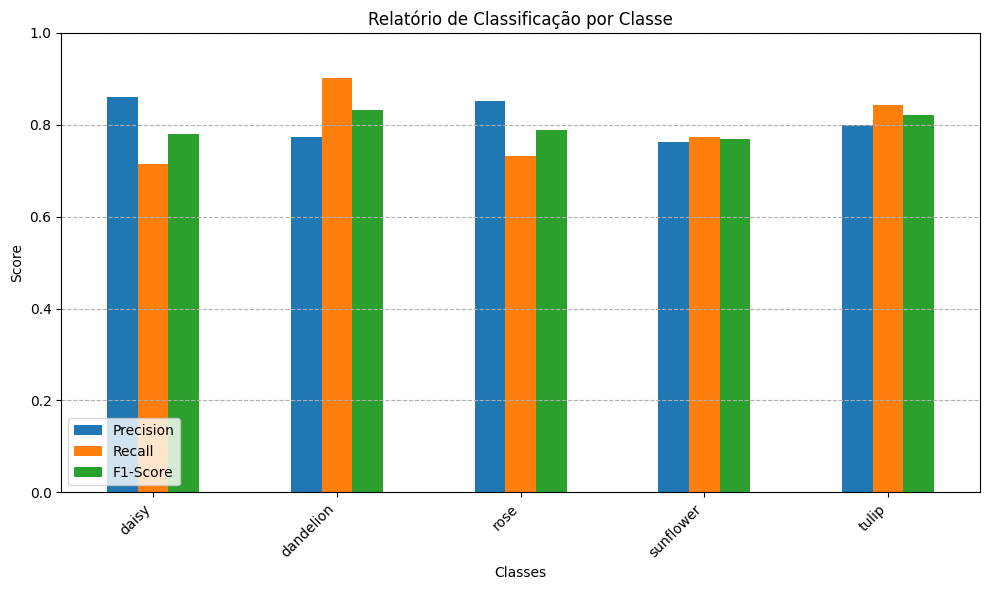


MATRIZ DE CONFUSÃO:
[[ 55  13   1   5   3]
 [  3 102   1   4   3]
 [  1   5  63   4  13]
 [  2   8   3  48   1]
 [  3   4   6   2  80]] 



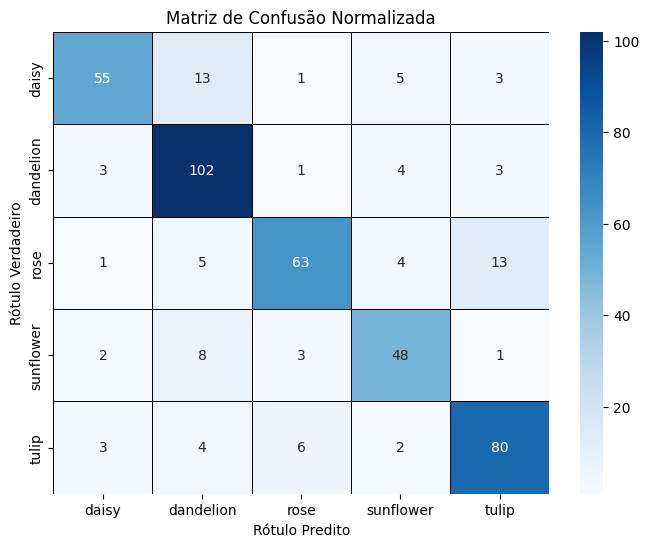

In [ ]:
# Lib para gerar o gráfico do relatório de classificação
import pandas as pd
# Lib para gerar a Matriz de Confusão como heatmap
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=.5,
        linecolor='black',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Matriz de Confusão Normalizada')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Predito')
    plt.show()

def plot_classification_report(report_dict, class_names):
    # Extrai as métricas de interesse (Precision, Recall, F1-Score) para as classes
    metrics = {
        'Precision': [report_dict[c]['precision'] for c in class_names],
        'Recall': [report_dict[c]['recall'] for c in class_names],
        'F1-Score': [report_dict[c]['f1-score'] for c in class_names]
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Relatório de Classificação por Classe')
    plt.ylabel('Score')
    plt.xlabel('Classes')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.0, 1.0) # Limita o eixo Y entre 0 e 1 para clareza
    plt.grid(axis='y', linestyle='--')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

print("\n--- AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---")

def evaluate_model(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)

    # 1. Acurácia
    test_accuracy = corrects.double() / total
    print(f"Acurácia Final no Teste: {test_accuracy:.4f}")

    # 2. Relatório de Classificação
    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
    print(classification_report(all_labels, all_preds, target_names=class_names), "\n")

    # Geração do Gráfico do Relatório
    plot_classification_report(report_dict, class_names)

    # 3. Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)

    print("\nMATRIZ DE CONFUSÃO:")
    print(cm, "\n")

    # Geração do Gráfico da Matriz de Confusão
    plot_confusion_matrix(cm, class_names)

evaluate_model(final_model, test_loader, class_names)